In [1]:
import numpy as np
import mne
import os 
import re
import matplotlib.pyplot as plt
%matplotlib inline
from util.io.read import load_conds

from util.stats import get_mann_whitney_u_test
from mne.stats import fdr_correction
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import balanced_accuracy_score, accuracy_score, make_scorer
from util.decoding import cross_val_predict_proba, auc_across_time
from mne.decoding import (cross_val_multiscore, LinearModel,
                          SlidingEstimator, get_coef)

# set seed for reproducibility 
np.random.seed(0)

# hard-coded values
CONDS = ["fundedAndUnfunded"]
EPOCHS_DIR = "epoched_data"

For classification, we implement logistic regression with an L2 penalty for regularization, i.e. logistic ridge regression. The weight of the penalty term (or strength of the regularizer) is determined as part the training procedure; it is set to whichever value maximizes stratified 10-folds cross-validation accuracy on the training set. The model is independently fit at each time point, hence "`SlidingEstimator`". For individual choice classification, our classes are imbalanced, so we will use class weights to balance the importance of our examples during training, so as to avoid our classifier being biased toward one class.

In [2]:
# define model pipeline
logistic_ridge = LogisticRegressionCV(solver = 'lbfgs', cv = 10, penalty = 'l2', 
                                      scoring = "roc_auc", class_weight = "balanced")
clf = make_pipeline(StandardScaler(), LinearModel(logistic_ridge))
time_decod = SlidingEstimator(clf, n_jobs = 1, scoring = "roc_auc", verbose = True)

To evaluate our classification performance, we train a model on all subjects but one and test on the one we left out. We do this $n$ times, where $n$ is the number of subjects, leaving a different subject out each time. We call this "leave-one-subject-out cross-validation." By measuring model performance only on examples the model hasn't seen during training, we can get an idea of how well the model will perform on _new_ subjects. We'll assess model performance with the area under the receiver-operator curve (AUC), since it doesn't depend on a specific decision threshold and is consequently a bit more robust to class-imbalances. 

In [3]:
# load individual choice data
X, y, subj_num, t = load_conds('yesAndNo', EPOCHS_DIR)

# evaluate leave-one-subject-out cross-validation AUC
cv_methd = LeaveOneGroupOut()
y_pred, y_true = cross_val_predict_proba(time_decod, X, y, groups = subj_num, 
                                         cv = cv_methd, n_jobs = 5)
yn_scores = auc_across_time(y_pred, y_true)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  11 out of  16 | elapsed: 39.2min remaining: 17.8min
[Parallel(n_jobs=5)]: Done  16 out of  16 | elapsed: 49.4min finished


We don't just want to compare classification accuracy against chance, though. Subjects risk losing their cash endowment when they choose to fund an appeal, so most subjects choose to fund a minority of projects. This means that our classifier would appear to perform "above chance" even if it just guessed that the subject picked "no" on every trial. Even though AUC is less sensitive to class imbalances than is accuracy, it isn't totally robust, so we're going to go an extra step and construct a "dummy classifier," which is going to always predict the class that maximizes the class prior. This is what we'll compare our model's performance too -- not chance performance, but still dumb performance. 

In [4]:
# define dummy model
dummy = DummyClassifier(strategy = "prior")
dummy_pipe = make_pipeline(StandardScaler(), dummy) # this is probably not needed 
dummy_decod = SlidingEstimator(dummy_pipe, n_jobs = 1, scoring = "roc_auc", verbose = False)

# evaluate it
y_pred, y_true = cross_val_predict_proba(dummy_decod, X, y, groups = subj_num, cv = cv_methd)
dummy_scores = auc_across_time(y_pred, y_true)

In [5]:
dummy_scores[0] # should be the same for all time points

0.2606443533697632

Okay, I lied. We _would_ have compared our model's performance to the dummy classifier, but the dummy classifier performs _much_ worse than chance. We can now rest assured that our particular combination of class imbalance and cross-validation scheme isn't positively biasing our classification performance. If anything, we're making things harder on ourselves. From here on out, we'll compare performance against chance, since that's evidently the more conservative thing to do.

AUC is actually just the effect size of a Mann-Whitney U-test, so that gives us a natural way to assess statistical significance. 

In [6]:
u_test = get_mann_whitney_u_test(np.bincount(y)[0], np.bincount(y)[1], alternative = 'greater')
yn_p = u_test(yn_scores)
# Benjamini–Hochberg correction for multiple comparisons
reject, _ = fdr_correction(yn_p) 

Now we'll plot our results so far. We'll highlight regions in which we exceed the current FDR-corrected significance threshold in yellow, but don't get too excited! We still have more comparisons to come, which we'll have to include in our FDR procedure, so we'll make another figure with the updated threshold below. This is just to help you keep track of where we're at so far.

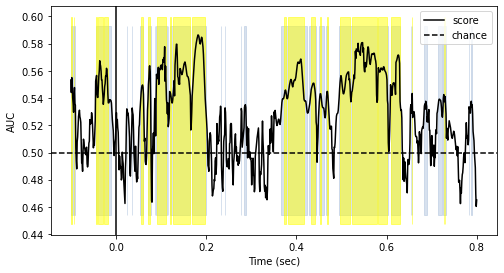

In [7]:
# visualize cross-validation accuracy over time
fig, ax = plt.subplots( figsize=(8, 4.2))
ax.plot(t, yn_scores, label = 'score', color = "black")
ax.axhline(.5, color = 'k', linestyle='--', label='chance')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('AUC')  
ax.legend()
ax.axvline(.0, color = 'k', linestyle = '-')
ax.set_title('')
ax.fill_between(t, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = yn_p < .05, color = 'lightsteelblue', alpha=0.5)
ax.fill_between(t, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = reject, color = 'yellow', alpha = 0.5)
plt.show()

Notably, we can predict an individual's decision _before they even see the stimulus._ So the state of the brain before the stimulus is presented (this could be the subject's mood, whether they're paying attention at the moment, etc.) seems to predict their subsequent choice. 

Now, we'll evaluate how well individual EEG traces can predict _group_-level outcomes -- whether the product succeeds on the market. This should obviously be invariant to the idiosyncratic state of the subjects' brains before stimulus onset.

In [8]:
# load market outcome data
X, y, subj_num, t = load_conds('fundedAndUnfunded', EPOCHS_DIR)

# evaluate leave-one-subject-out cross-validation AUC
cv_methd = LeaveOneGroupOut()
y_pred, y_true = cross_val_predict_proba(time_decod, X, y, groups = subj_num, 
                                         cv = cv_methd, n_jobs = 5)
fu_scores = auc_across_time(y_pred, y_true)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  11 out of  16 | elapsed: 34.1min remaining: 15.5min
[Parallel(n_jobs=5)]: Done  16 out of  16 | elapsed: 43.2min finished


Genevsky and colleagues (2017), using the same experimental design, opted to compare the group-level predictive performance to performance when classifying faces vs. places. The idea was to show that they weren't just classifying responses to visual features but actual choice processes. Visually evoked potentials are almost by definition responses to visual features, but we think that variation in these responses may nonetheless be choice-related. Thus, the face vs. place distinction isn't particularly important to us theoretically, but we'll evaluate whether face/place information is being used by our funded/unfunded classifier anyway to increase the specificity of our claims.

In [9]:
# load stimulus data
X, y, subj_num, t = load_conds('faceAndPlace', EPOCHS_DIR)
# and score
fp_scores = auc_across_time(y_pred, y)

Now, we can compare the funded vs. unfunded scores to chance AUC. Since we'll have then made all the comparisons we're going to make re: classifier performance, we can make our real FDR correction and plot some real results.

In [10]:
# test market predictions against chance
fu_p = u_test(fu_scores)

# correct for multiple comparisons
p = np.concatenate([yn_p, fu_p]) 
reject, _ = fdr_correction(p)
alpha = max(p[reject]) # FDR corrected alpha
alpha

0.009783718820905906

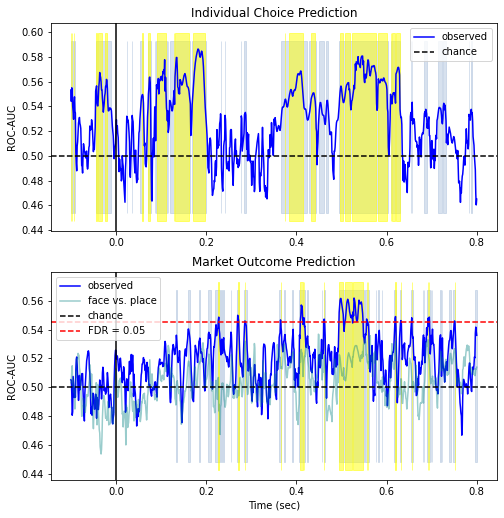

In [11]:
# visualize cross-validation accuracy over time
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 8.4))
# plot individual choice
ax = axs[0]
ax.plot(t, yn_scores, label = 'observed', color = "blue")
ax.axhline(.5, color = 'k', linestyle='--', label='chance')
ax.set_ylabel('ROC-AUC')  
ax.legend()
ax.axvline(.0, color = 'k', linestyle = '-')
ax.set_title('Individual Choice Prediction')
ax.fill_between(t, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = yn_p < .05, color = 'lightsteelblue', alpha = 0.5)
ax.fill_between(t, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = yn_p <= alpha, color = 'yellow', alpha = 0.5)
# and then group choice
ax = axs[1]
ax.plot(t, fu_scores, label = 'observed', color = "blue")
ax.plot(t, fp_scores, label = 'face vs. place', color = "teal", alpha = .4)
ax.axhline(.5, color = 'k', linestyle = '--', label = 'chance')
corrected_thresh = min(fu_scores[fu_p <= alpha])
ax.axhline(corrected_thresh, color = 'red', linestyle='--', label = 'FDR = 0.05')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('ROC-AUC')  
ax.legend()
ax.axvline(.0, color = 'k', linestyle = '-')
ax.set_title('Market Outcome Prediction')
ax.fill_between(t, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = fu_p < .05, color = 'lightsteelblue', alpha = 0.5)
ax.fill_between(t, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = fu_p <= alpha, color = 'yellow', alpha = 0.5)
# done!
plt.show()

Okay, cool. This ties in nicely with Genevsky et al.'s (2017) narrative that _some_ components of individual choice also predict group preference (market outcomes) but not those that are idiosyncratic to the subject. Nothing is more idiosyncratic to the subject than prestimulus activity, which obviously has _nothing_ to do with the stimulus. But they presented a sort of stage model in which (in their case, affective) activity that predicts both market outcomes and individual choice temporally preceeds the activity that only predicts individual choice, which is obviously not true in our results. So the superior temporal resolution of EEG has afforded us a good bit of additional nuance in explaining the phenomenon of "neuroforecasting."

Now, let's see what patterns the models have identified that differentiate choice behaviors. First, we have to train the models on the full dataset (not just cross-validation folds) to get their full weights. Let's again start with the individual choice model.

In [12]:
X, y, _, t, info = load_conds('yesAndNo', EPOCHS_DIR, include_info = True)
time_decod.fit(X, y) # get final model weights

  0%|          | Fitting SlidingEstimator : 0/901 [00:00<?,       ?it/s]

<SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel',
                 LinearModel(model=LogisticRegressionCV(class_weight='balanced', cv=10, scoring='roc_auc')))]),
         n_jobs=1, scoring='roc_auc', verbose=True, fitted with 901 estimators>

Now we have the coefficients for the full model, but plotting those won't be very informative. In particular, shared noise between electrodes is going to cause arbitrary electrodes to have large coefficients. Consider a situation in which some signal, $S$, is predictive of choice outcomes, and $S$ shows up in electrode $A$. However, noise $N$ also shows up in electrode $A$, so $A = S + N$. Luckily, electrode $B$ has no signal but does share the same noise, so $B = N$. Thus, our model can recover $S$ by subtracting $A - B = (S + N) - N = S$, and it will improve prediction to give a nonzero coefficient to $B$, even though $B$ has no signal.

So instead of visualizing the raw coefficients, we reverse the model, plotting _patterns_ of activity that cause our model to predict a trial is in the positive class with high probability, using a trick described by [Haufe et al. (2014)](doi:10.1016/j.neuroimage.2013.10.067).

No projector specified for this dataset. Please consider the method self.add_proj.


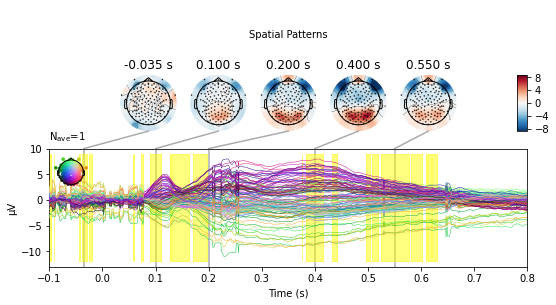

In [13]:
# compute patterns from coefficients
coef = get_coef(time_decod, 'patterns_', inverse_transform = True)
yn_evoked = mne.EvokedArray(coef, info, tmin = t[0])

# plot patterns
joint_kwargs = dict(ts_args = dict(time_unit = 's'),
                    topomap_args = dict(time_unit = 's'))
fig = yn_evoked.plot_joint(times = np.array([-.035, .1, .2, .4, .525]), 
                           title = 'Spatial Patterns',
                           show = False,
                           **joint_kwargs)
ax = fig.axes[0] # axis for butterfly plot
ax.fill_between(t, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = yn_p <= alpha, 
                color = 'yellow', 
                alpha = 0.5)
plt.show()

And now we do the same for the market outcome model.

In [14]:
X, y, _, t, info = load_conds('fundedAndUnfunded', EPOCHS_DIR, include_info = True)
time_decod.fit(X, y) # get final model weights

  0%|          | Fitting SlidingEstimator : 0/901 [00:00<?,       ?it/s]

<SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel',
                 LinearModel(model=LogisticRegressionCV(class_weight='balanced', cv=10, scoring='roc_auc')))]),
         n_jobs=1, scoring='roc_auc', verbose=True, fitted with 901 estimators>

No projector specified for this dataset. Please consider the method self.add_proj.


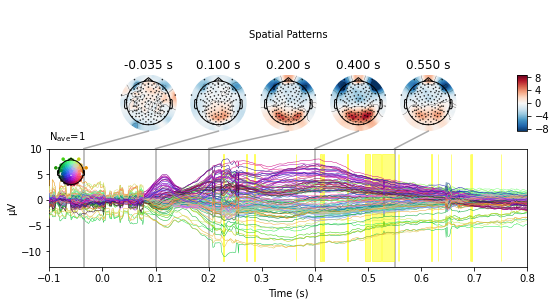

In [15]:
coef = get_coef(time_decod, 'patterns_', inverse_transform = True)
fu_evoked = mne.EvokedArray(coef, info, tmin = t[0])

joint_kwargs = dict(ts_args = dict(time_unit = 's'),
                    topomap_args = dict(time_unit = 's'))
fig = yn_evoked.plot_joint(times = np.array([-.035,.1, .2, .4, .525]), 
                           title = 'Spatial Patterns',
                           show = False,
                           **joint_kwargs)
ax = fig.axes[0]
ax.fill_between(t, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = fu_p <= alpha, 
                color = 'yellow', 
                alpha = 0.5)
plt.show()